In [1]:
## rev 1 is solution for proj5
## rev 2 is update rev as apply like dropout
##          for optimize: adding more time of g opt...


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

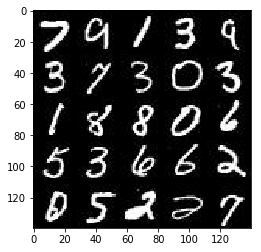

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

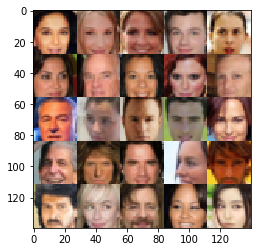

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    #return None, None, None
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    #keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.65):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :alpha      : leak_relu
    :keep_prob  : dropout keep probility
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(alpha * x1, x1)
        #out: 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #out: 7x7x128
        
        # follow suggestion, change kernel size from 256 -> 512
        # number of filters (the dimensionality of the output space) gives the ability to learn more different details
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=1, padding='same', 
                              kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #out: 7x7x256
        
        #dropout
        dropout = tf.nn.dropout(relu3, keep_prob)
        
        # Flatten it
        flat = tf.reshape(dropout, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    #return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.65):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :alpha: leak_relu
    :keep_prob: dropout keep probility
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1  = tf.maximum(alpha * bn1, bn1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x64 now
        
        #dropout
        dropout = tf.nn.dropout(lrelu3, keep_prob)
        
        # Output layer
        # follow suggestion: switch layer1 and layer3 strides, remove the chessboard effect.
        logits = tf.layers.conv2d_transpose(dropout, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x5 now
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_real)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)*smooth))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    #model_inputs(image_width, image_height, image_channels, z_dim)
    # -> return inputs_real, inputs_z, learning_rate
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    
    #saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Multiply batch_images by 2since the dataset ranges from -0.5 to 0.5
                #images = batch_images * 2.0 # incorrect
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images}) # optimize g twice time
    
                # every 20 steps PRINT
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))
                
                # show image every 100 step
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt') 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6111... Generator Loss: 0.4143
Epoch 1/2... Discriminator Loss: 2.2436... Generator Loss: 0.4739
Epoch 1/2... Discriminator Loss: 2.1904... Generator Loss: 0.4822
Epoch 1/2... Discriminator Loss: 2.4730... Generator Loss: 0.3899
Epoch 1/2... Discriminator Loss: 1.9389... Generator Loss: 0.5085


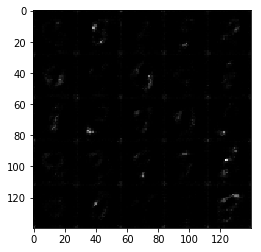

Epoch 1/2... Discriminator Loss: 1.7265... Generator Loss: 0.5813
Epoch 1/2... Discriminator Loss: 2.0621... Generator Loss: 0.4831
Epoch 1/2... Discriminator Loss: 1.7414... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.8706... Generator Loss: 1.3825
Epoch 1/2... Discriminator Loss: 1.6932... Generator Loss: 1.2499


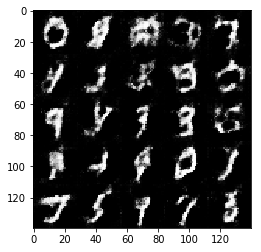

Epoch 1/2... Discriminator Loss: 1.9447... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 1.8655... Generator Loss: 0.9761
Epoch 1/2... Discriminator Loss: 2.0133... Generator Loss: 1.3111
Epoch 1/2... Discriminator Loss: 1.7763... Generator Loss: 1.1576
Epoch 1/2... Discriminator Loss: 1.6992... Generator Loss: 1.2653


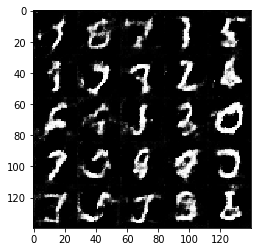

Epoch 1/2... Discriminator Loss: 1.8507... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 1.5309... Generator Loss: 0.7921
Epoch 1/2... Discriminator Loss: 1.7540... Generator Loss: 1.4614
Epoch 1/2... Discriminator Loss: 1.7956... Generator Loss: 0.4733
Epoch 1/2... Discriminator Loss: 2.1256... Generator Loss: 0.4220


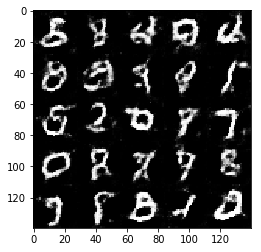

Epoch 1/2... Discriminator Loss: 1.6725... Generator Loss: 1.0663
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.6092... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 1.7439... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 0.6433


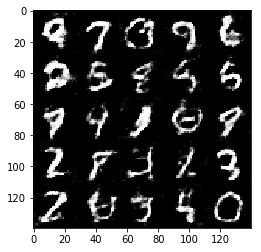

Epoch 1/2... Discriminator Loss: 1.6911... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 1.6981... Generator Loss: 0.5667
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.9712
Epoch 1/2... Discriminator Loss: 1.4896... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 1.0247


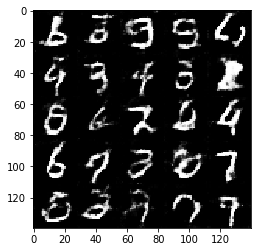

Epoch 1/2... Discriminator Loss: 1.7662... Generator Loss: 1.4006
Epoch 1/2... Discriminator Loss: 1.8540... Generator Loss: 0.4275
Epoch 1/2... Discriminator Loss: 1.5592... Generator Loss: 0.7539


KeyboardInterrupt: 

In [17]:
batch_size = 64 # GANs sometimes a smaller batch size works better
# batch_size as a power of 2
z_dim = 100
learning_rate = 0.0005 # change from 0.0001 -> 0.005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.7086... Generator Loss: 2.8756
Epoch 1/1... Discriminator Loss: 2.3733... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 4.6233... Generator Loss: 8.1418
Epoch 1/1... Discriminator Loss: 7.3015... Generator Loss: 5.9122
Epoch 1/1... Discriminator Loss: 2.5983... Generator Loss: 2.3387


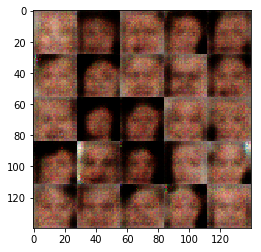

Epoch 1/1... Discriminator Loss: 2.4186... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 2.4048... Generator Loss: 2.3058
Epoch 1/1... Discriminator Loss: 1.9870... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 1.6964... Generator Loss: 0.7722


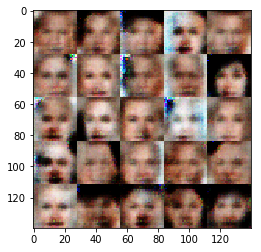

Epoch 1/1... Discriminator Loss: 1.9628... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.9362... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 1.8439... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.8449... Generator Loss: 0.5348


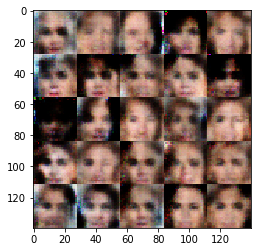

Epoch 1/1... Discriminator Loss: 1.9089... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 1.7872... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.8127... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 2.5225... Generator Loss: 1.3905


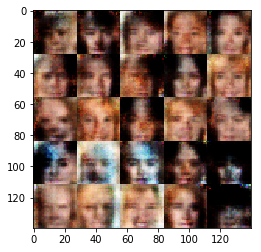

Epoch 1/1... Discriminator Loss: 1.6660... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.7410... Generator Loss: 0.6899


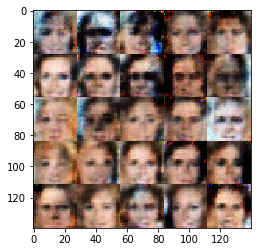

Epoch 1/1... Discriminator Loss: 2.0797... Generator Loss: 1.4477
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.7616... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.7115... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 2.1279... Generator Loss: 0.5769


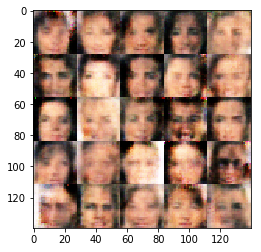

Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.6558... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.8074... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 2.3646... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.7999


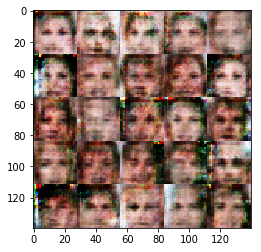

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.6328... Generator Loss: 0.8944


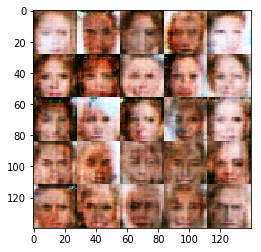

Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8699


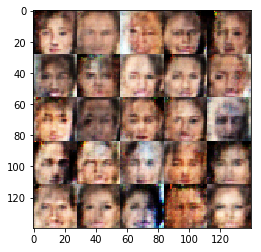

Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 0.5411


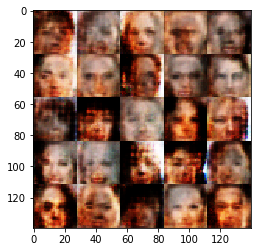

Epoch 1/1... Discriminator Loss: 1.6400... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8463


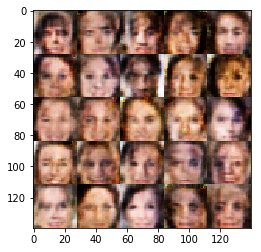

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.8265


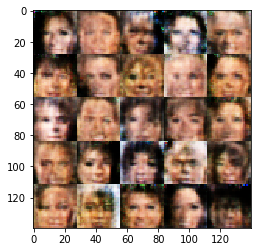

Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8430


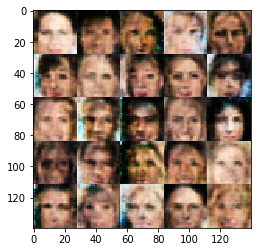

Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6597


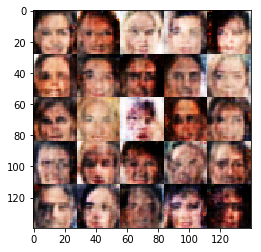

Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7172


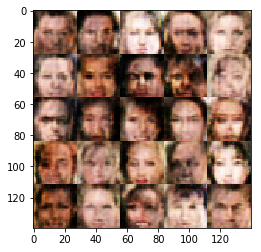

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.8352


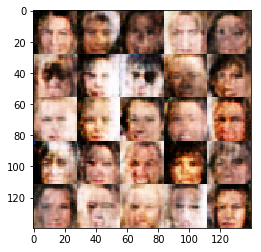

Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 2.2084... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6920


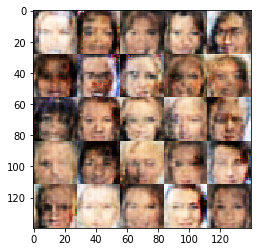

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.7478


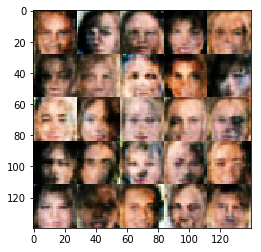

Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.6484... Generator Loss: 0.9405


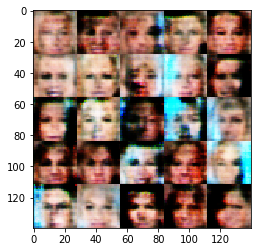

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6767


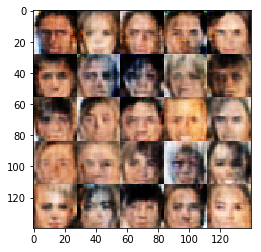

Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8843


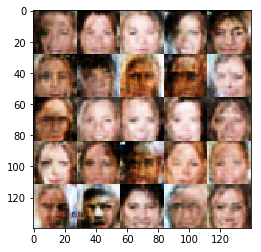

Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7873


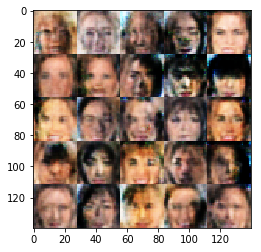

Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.8038


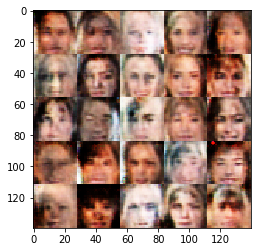

Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.7248... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.7670


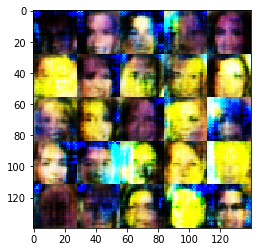

Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.8142


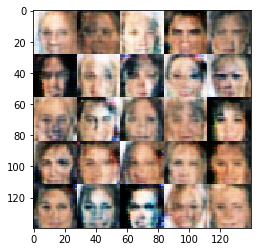

Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 2.5487... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.8334


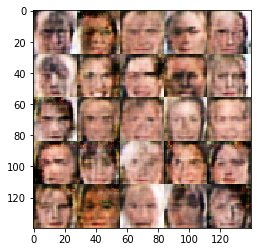

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8359


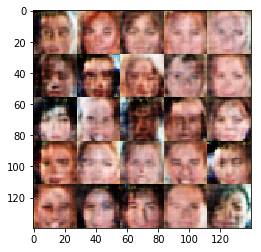

Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.8086


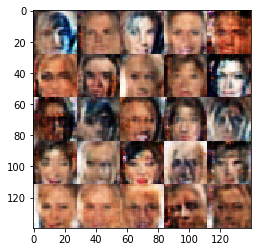

Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8401


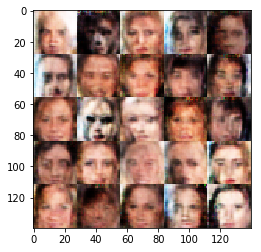

Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7226


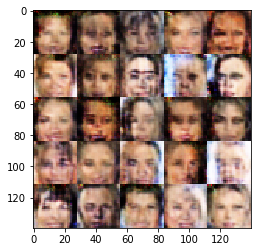

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.8053


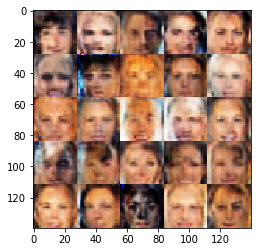

Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.7285


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.